<a href="https://colab.research.google.com/github/shadenAlsaif/network_intrusion_detection_system/blob/main/AI_for_CS_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading

Mount data from drive

In [ ]:
from google.colab import drive
import pandas as pd
import glob

drive.mount('/content/drive')

Mounted at /content/drive


Merge 8 CSV files into one

In [ ]:
import os, warnings, glob
import pandas as pd

path = "/content/drive/MyDrive/Project Data/CIC-IDS 2017 data/"
files = glob.glob(os.path.join(path, "*.csv"))

dfs = []
for f in files:
    df = pd.read_csv(f)
    dfs.append(df)

if dfs:
    full_df = pd.concat(dfs, ignore_index=True)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        if "Label" in full_df.columns:
            full_df = full_df.groupby("Label", group_keys=False).apply(
                lambda x: x.sample(frac=min(500000/len(full_df), 1.0), random_state=42)
            )
        else:
          # randomly select 500k rows
            full_df = full_df.sample(n=min(500000, len(full_df)), random_state=42)

    print("✅ Data loaded and sampled:", full_df.shape)
else:
    print("❌ No CSV files were loaded. Check the folder path.")

✅ Data loaded and sampled: (500000, 79)


Column names

In [ ]:
full_df.columns = full_df.columns.str.strip()
full_df.columns.to_list()

['Destination Port',
 'Flow Duration',
 'Total Fwd Packets',
 'Total Backward Packets',
 'Total Length of Fwd Packets',
 'Total Length of Bwd Packets',
 'Fwd Packet Length Max',
 'Fwd Packet Length Min',
 'Fwd Packet Length Mean',
 'Fwd Packet Length Std',
 'Bwd Packet Length Max',
 'Bwd Packet Length Min',
 'Bwd Packet Length Mean',
 'Bwd Packet Length Std',
 'Flow Bytes/s',
 'Flow Packets/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Total',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Total',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Length',
 'Bwd Header Length',
 'Fwd Packets/s',
 'Bwd Packets/s',
 'Min Packet Length',
 'Max Packet Length',
 'Packet Length Mean',
 'Packet Length Std',
 'Packet Length Variance',
 'FIN Flag Count',
 'SYN Flag Count',
 'RST Flag Count',
 'PSH Flag Count',
 'ACK Flag Count',
 'UR

Num of columns

In [ ]:
full_df.shape[1]

79

Display data

In [ ]:
full_df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
746827,50545,232,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
946912,53,31226,2,2,68,380,34,34,34.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2216843,80,99951883,9,7,317,11595,317,0,35.222222,105.666667,...,32,999.0,0.0,999,999,99900000.0,0.0,99900000,99900000,DoS Hulk
699389,53,30894,4,2,140,172,35,35,35.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1170268,53,48943,2,2,88,166,44,44,44.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


# Data Preprocessing

Merged attack types under "ATTACK"

In [ ]:
full_df["Label"] = full_df["Label"].apply(lambda x: "BENIGN" if x == "BENIGN" else "ATTACK")
print(full_df["Label"].value_counts())
print(full_df["Label"].value_counts(normalize=True).mul(100).round(2))

Label
BENIGN    401419
ATTACK     98581
Name: count, dtype: int64
Label
BENIGN    80.28
ATTACK    19.72
Name: proportion, dtype: float64


Clean data (drop duplicates, nulls, and handle infinite values)

In [ ]:
import numpy as np

# Drop duplicates
full_df = full_df.drop_duplicates()

# Replace inf with NaN, then drop NaN
full_df = full_df.replace([np.inf, -np.inf], np.nan)
full_df = full_df.dropna()

# EDA

1️⃣ Class Distribution (Benign vs Attack)

Question:
What is the overall balance between benign and attack traffic in the dataset?

Interpretation:
The dataset is imbalanced, with ~82% benign traffic and ~18% attack traffic. This imbalance may bias models toward predicting benign, so it needs to be accounted for during modeling.

/tmp/ipython-input-2070443081.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Label", data=full_df, palette="Set2")


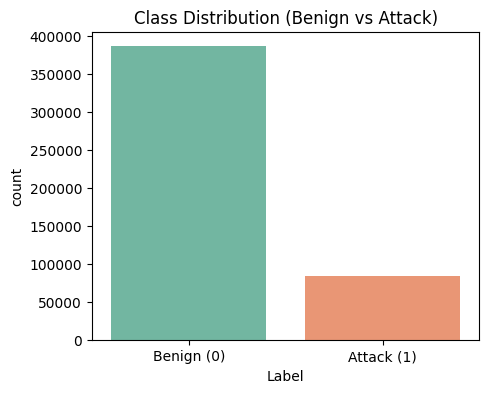

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.countplot(x="Label", data=full_df, palette="Set2")
plt.title("Class Distribution (Benign vs Attack)")
plt.xticks([0,1], ["Benign (0)", "Attack (1)"])
plt.show()

2️⃣ Packet Length Std by Class

Question:
Do packet size variations (Packet Length Std) differ between benign and attack traffic?

Interpretation:
Benign traffic is tightly clustered around smaller values, while attack traffic shows higher variability and longer tails. This indicates packet length variation is a strong discriminator between normal and malicious flows.

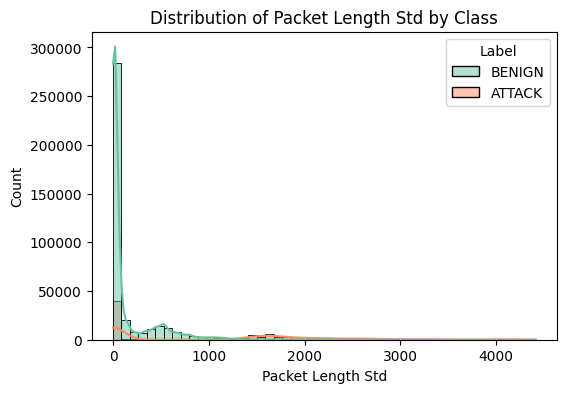

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(data=full_df, x="Packet Length Std", hue="Label", bins=50, kde=True, palette="Set2")
plt.title("Distribution of Packet Length Std by Class")
plt.show()

3️⃣ Top 15 Destination Ports (Benign vs Attack)

Question:
Are certain destination ports more associated with attacks compared to benign traffic?

Interpretation:
Some ports (e.g., 80, 22) are heavily targeted in attacks, while others (e.g., 53, 443) appear predominantly in benign traffic. This highlights port usage as a valuable feature for distinguishing malicious activity.

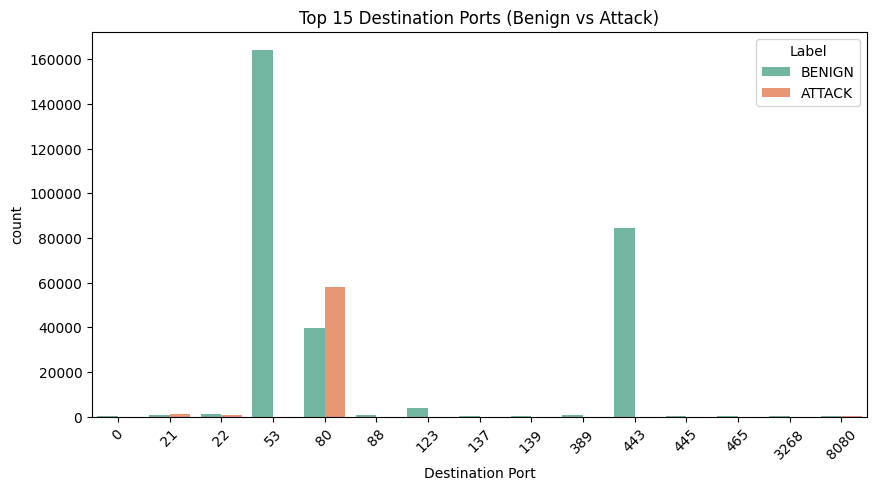

In [ ]:
plt.figure(figsize=(10,5))
top_ports = full_df["Destination Port"].value_counts().head(15).index
sns.countplot(data=full_df[full_df["Destination Port"].isin(top_ports)],
              x="Destination Port", hue="Label", palette="Set2")
plt.title("Top 15 Destination Ports (Benign vs Attack)")
plt.xticks(rotation=45)
plt.show()

4️⃣ Avg Bwd Segment Size by Class

Question:
Do backward segment sizes differ between benign and attack traffic?

Interpretation:
Benign traffic generally has small backward segment sizes, while attacks show larger and more variable values. This emphasizes the role of backward packet behavior in detecting intrusions.


/tmp/ipython-input-3499610411.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=full_df, x="Label", y="Avg Bwd Segment Size", palette="Set2")


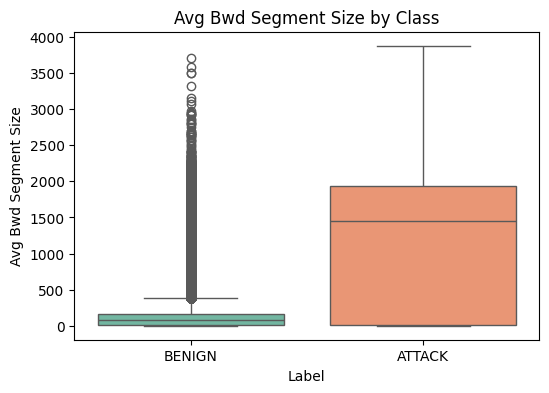

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(data=full_df, x="Label", y="Avg Bwd Segment Size", palette="Set2")
plt.title("Avg Bwd Segment Size by Class")
plt.show()

# Feature Engineering

Handle labels (Binary)

In [ ]:
y = full_df["Label"].apply(lambda x: 0 if x=="BENIGN" else 1)
X = full_df.drop(columns=["Label"])

Scale features (normalize)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Train-Test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

print(X_train.shape, X_test.shape)

(375956, 78) (93990, 78)


## Feature Ranking

1. Random Forest Feature Importance
- Ranks features based on how much they reduce impurity when splitting in decision trees.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

rf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

importances = rf.feature_importances_
rf_ranking = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print(rf_ranking.head(15))

Max Packet Length          0.081110
Packet Length Std          0.071116
Average Packet Size        0.061380
Packet Length Variance     0.060197
Avg Bwd Segment Size       0.050474
Bwd Packet Length Max      0.040290
Destination Port           0.036953
Bwd Packet Length Std      0.036611
Init_Win_bytes_forward     0.029281
Init_Win_bytes_backward    0.029061
Subflow Fwd Bytes          0.028427
Fwd Packet Length Max      0.027893
Avg Fwd Segment Size       0.027420
Packet Length Mean         0.025567
Fwd Packet Length Mean     0.021688
dtype: float64


2. Gradient Boosting (XGBoost)
- Measures how often and how effectively each feature is used to improve tree splits during gradient boosting.

In [ ]:
from xgboost import XGBClassifier
import pandas as pd

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb.fit(X_train, y_train)

xgb_importances = pd.Series(
    xgb.feature_importances_, index=X.columns
).sort_values(ascending=False)

print(xgb_importances.head(15))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:30:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Average Packet Size            0.210777
Bwd Packet Length Std          0.139188
Fwd Packet Length Mean         0.110768
Avg Bwd Segment Size           0.094963
Max Packet Length              0.055649
Bwd Header Length              0.054362
Fwd Header Length.1            0.042159
Bwd Packet Length Mean         0.037483
Fwd Packet Length Max          0.033715
Packet Length Std              0.026936
Total Fwd Packets              0.014476
Active Std                     0.011676
FIN Flag Count                 0.010159
Total Length of Bwd Packets    0.009822
Destination Port               0.009462
dtype: float32


Comparison Plot

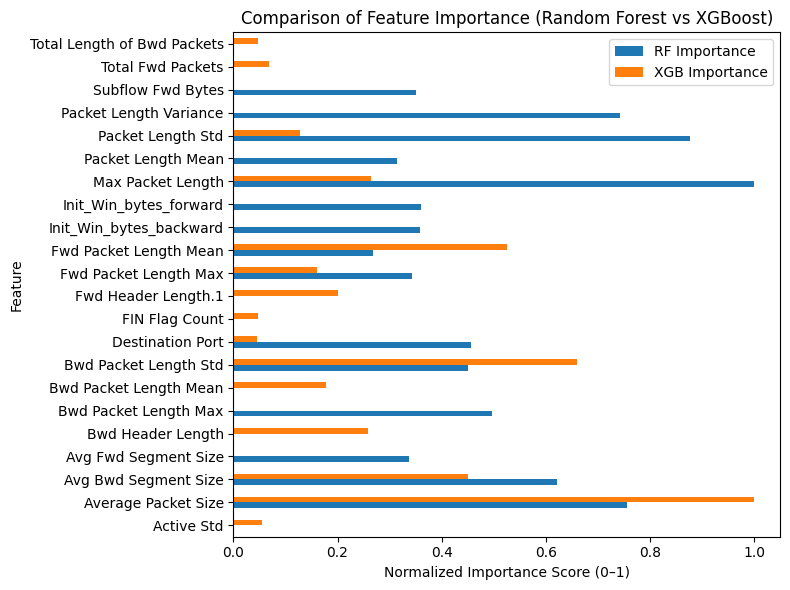

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert importances to DataFrames
rf_df = rf_ranking.head(15).reset_index()
rf_df.columns = ["Feature", "RF Importance"]

xgb_df = xgb_importances.head(15).reset_index()
xgb_df.columns = ["Feature", "XGB Importance"]

# Merge on Feature
merge_df = pd.merge(rf_df, xgb_df, on="Feature", how="outer").fillna(0)

# Normalize both to 0–1 for fair comparison
merge_df["RF Importance"] /= merge_df["RF Importance"].max()
merge_df["XGB Importance"] /= merge_df["XGB Importance"].max()

# Plot
merge_df.set_index("Feature").plot(kind="barh", figsize=(8,6))
plt.title("Comparison of Feature Importance (Random Forest vs XGBoost)")
plt.xlabel("Normalized Importance Score (0–1)")
plt.tight_layout()
plt.show()

## Feature Elimination

Keep top 20 features in common

In [ ]:
# Combine RF + XGB importances (normalize then average)
combined_importances = (
    (rf_ranking / rf_ranking.max()) +
    (xgb_importances / xgb_importances.max())
) / 2

# Select top 20 features
selected_features = combined_importances.sort_values(ascending=False).head(20).index.tolist()

X_train_reduced = pd.DataFrame(X_train, columns=X.columns)[selected_features]
X_test_reduced = pd.DataFrame(X_test, columns=X.columns)[selected_features]

print("Final Selected Features (20):")
for i, feat in enumerate(selected_features, 1):
    print(f"{i:2d}. {feat}")

Final Selected Features (20):
 1. Average Packet Size
 2. Max Packet Length
 3. Bwd Packet Length Std
 4. Avg Bwd Segment Size
 5. Packet Length Std
 6. Fwd Packet Length Mean
 7. Packet Length Variance
 8. Bwd Packet Length Max
 9. Fwd Packet Length Max
10. Destination Port
11. Bwd Header Length
12. Bwd Packet Length Mean
13. Init_Win_bytes_backward
14. Init_Win_bytes_forward
15. Fwd Header Length.1
16. Subflow Fwd Bytes
17. Avg Fwd Segment Size
18. Packet Length Mean
19. Total Length of Bwd Packets
20. Total Fwd Packets


Update test and train sets' columns

In [ ]:
# Update train and test to only keep the selected features
X_train = X_train_reduced.copy()
X_test = X_test_reduced.copy()

print("Updated shapes -> Train:", X_train.shape, " Test:", X_test.shape)

Updated shapes -> Train: (375956, 20)  Test: (93990, 20)


## Plot

Question: Are the most important 20 features highly correlated, or do they provide distinct information?

Observation: Several packet size–related features (e.g., Average Packet Size, Max Packet Length, Packet Length Std, Packet Length Variance) are strongly correlated, suggesting redundancy. Other features like Destination Port, Init_Win_bytes_forward, and Bwd Header Length show weaker correlations, providing unique information.

Implication: The feature selection captured both correlated features (reinforcing packet size importance) and distinct features (ports, header fields), ensuring a balanced and informative set for modeling.

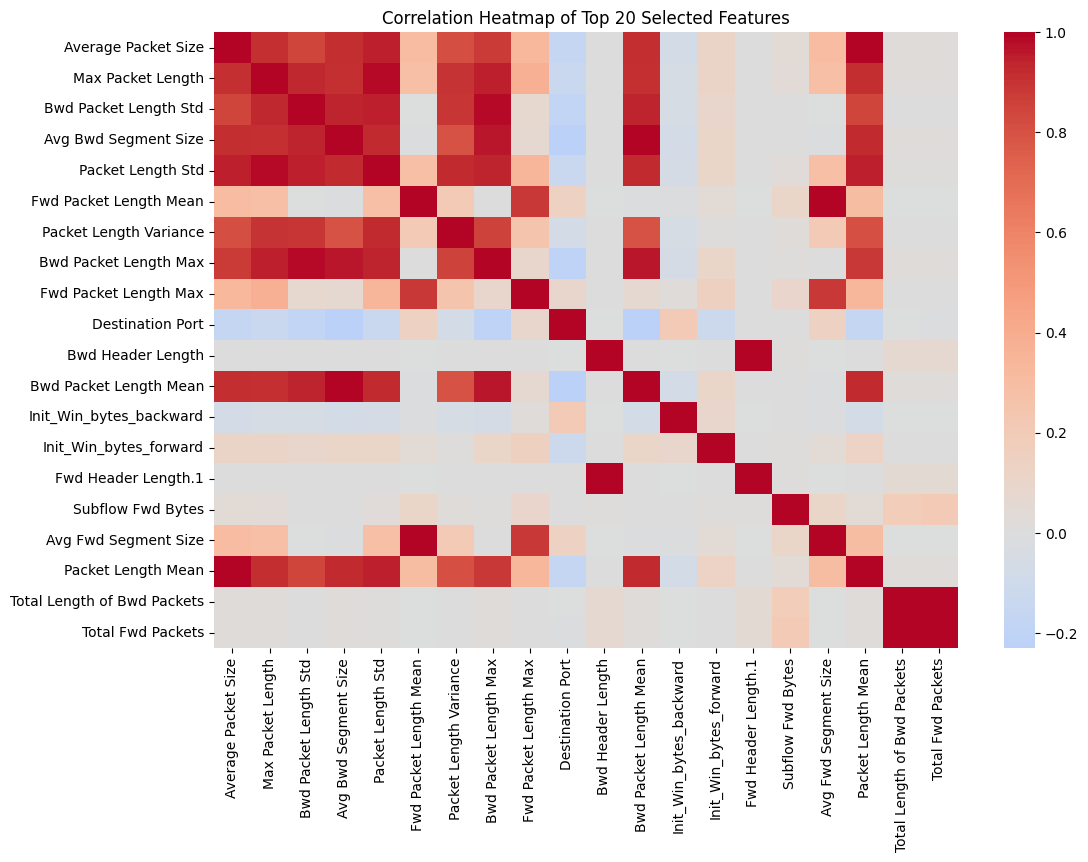

In [ ]:
plt.figure(figsize=(12,8))
corr_top20 = full_df[selected_features].corr()
sns.heatmap(corr_top20, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Heatmap of Top 20 Selected Features")
plt.show()

# Model Training and Evaluation

In [ ]:
# Core ML libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Evaluation tools
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [ ]:
# Function to compute and print evaluation metrics
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    print(f"\n=== {model_name} ===")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))

    # ROC-AUC (requires probability scores)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)

    print("ROC-AUC  :", roc_auc_score(y_test, y_prob))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


=== Logistic Regression ===
Accuracy : 0.8864985636769869
Precision: 0.6210526315789474
Recall   : 0.9394011406844106
F1 Score : 0.7477537122860115
ROC-AUC  : 0.9537686127692453


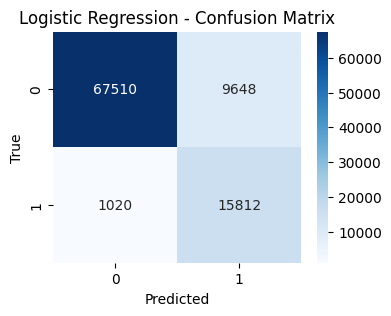

In [ ]:
# Logistic Regression model (baseline)
lr = LogisticRegression(
    class_weight="balanced",
    max_iter=200,
    n_jobs=-1
)

lr.fit(X_train, y_train)
evaluate_model(lr, X_test, y_test, "Logistic Regression")


=== Random Forest ===
Accuracy : 0.9964783487605064
Precision: 0.9814998540997958
Recall   : 0.9991682509505704
F1 Score : 0.9902552477404539
ROC-AUC  : 0.9997114424181155


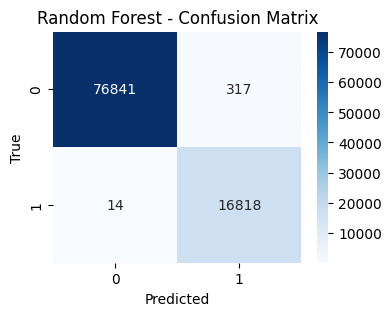

In [ ]:
# Random Forest model
rf_clf = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)
evaluate_model(rf_clf, X_test, y_test, "Random Forest")


=== XGBoost ===
Accuracy : 0.9961804447281626
Precision: 0.9793400453937031
Recall   : 0.9997623574144486
F1 Score : 0.9894458327208584
ROC-AUC  : 0.9998615043878902


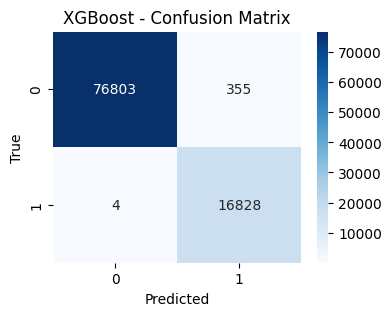

In [ ]:
# Compute scale_pos_weight for imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# XGBoost model
xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb_clf.fit(X_train, y_train)
evaluate_model(xgb_clf, X_test, y_test, "XGBoost")

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(



=== MLP Neural Network ===
Accuracy : 0.9632301308649857
Precision: 0.851039260969977
Recall   : 0.9632842205323194
F1 Score : 0.9036896667038234
ROC-AUC  : 0.9958877719692159


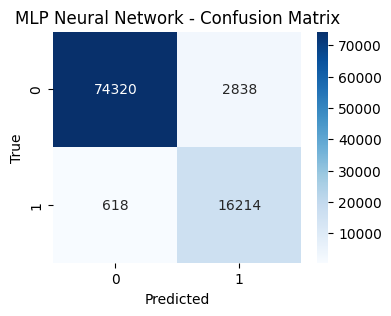

In [ ]:
# MLP neural network for tabular data
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=20,
    random_state=42
)

mlp.fit(X_train, y_train)
evaluate_model(mlp, X_test, y_test, "MLP Neural Network")

In [ ]:
# Collect metrics for comparison
results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

def collect_metrics(model, name):
    y_pred = model.predict(X_test)
    results["Model"].append(name)
    results["Accuracy"].append(accuracy_score(y_test, y_pred))
    results["Precision"].append(precision_score(y_test, y_pred))
    results["Recall"].append(recall_score(y_test, y_pred))
    results["F1 Score"].append(f1_score(y_test, y_pred))

collect_metrics(lr, "Logistic Regression")
collect_metrics(rf_clf, "Random Forest")
collect_metrics(xgb_clf, "XGBoost")
collect_metrics(mlp, "MLP Neural Network")

# Create DataFrame and sort by Accuracy
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)

results_df

,Model,Accuracy,Precision,Recall,F1 Score
1,Random Forest,0.996478,0.981500,0.999168,0.990255
2,XGBoost,0.996180,0.979340,0.999762,0.989446
3,MLP Neural Network,0.963230,0.851039,0.963284,0.903690
0,Logistic Regression,0.886499,0.621053,0.939401,0.747754


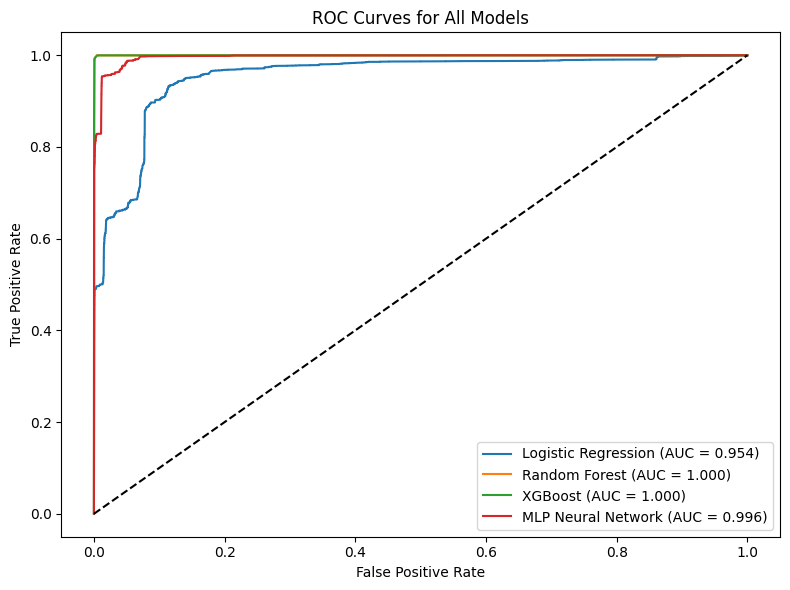

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

models = {
    "Logistic Regression": lr,
    "Random Forest": rf_clf,
    "XGBoost": xgb_clf,
    "MLP Neural Network": mlp
}

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

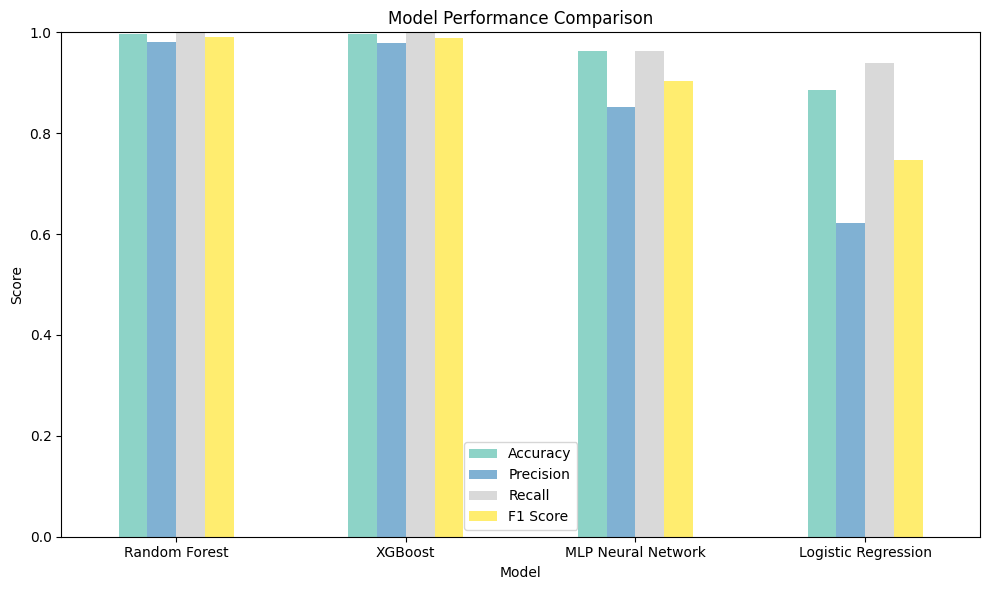

In [ ]:
plt.figure(figsize=(10,6))
results_df.set_index("Model")[["Accuracy","Precision","Recall","F1 Score"]].plot(
    kind="bar", figsize=(10,6), cmap="Set3"
)

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()